# 主函数

In [2]:
import copy
from itertools import product
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

# 复合块的最小填充率
MIN_FILL_RATE = 0.9
# 可行放置矩形与相应复合块顶部面积比的最小值
MIN_AREA_RATE = 0.9
# 复合块最大复杂度
MAX_TIMES = 2
# 搜索树深度
MAX_DEPTH = 3
# 搜索树节点分支数
MAX_BRANCH = 2

# 临时的最优放置方案
tmp_best_ps = None


# 栈数据结构，用于存储剩余空间
class Stack:
    def __init__(self):
        self.data = []

    def empty(self):
        return len(self.data) == 0

    def not_empty(self):
        return len(self.data) > 0

    def pop(self):
        return self.data.pop() if len(self.data) > 0 else None

    def push(self, *items):
        for item in items:
            self.data.append(item)

    def top(self):
        return self.data[len(self.data) - 1] if len(self.data) > 0 else None

    def clear(self):
        self.data.clear()

    def size(self):
        return len(self.data)


# 箱子类
class Box:
    def __init__(self, lx, ly, lz, type=0):
        # 长
        self.lx = lx
        # 宽
        self.ly = ly
        # 高
        self.lz = lz
        # 类型
        self.type = type

    def __str__(self):
        return "lx: {}, ly: {}, lz: {}, type: {}".format(self.lx, self.ly, self.lz, self.type)


# 剩余空间类
class Space:
    def __init__(self, x, y, z, lx, ly, lz, origin=None):
        # 坐标
        self.x = x
        self.y = y
        self.z = z
        # 长
        self.lx = lx
        # 宽
        self.ly = ly
        # 高
        self.lz = lz
        # 表示从哪个剩余空间切割而来
        self.origin = origin

    def __str__(self):
        return "x:{},y:{},z:{},lx:{},ly:{},lz:{}".format(self.x, self.y, self.z, self.lx, self.ly, self.lz)

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y and self.z == other.z and self.lx == other.lx and self.ly == other.ly and self.lz == other.lz


# 装箱问题类
class Problem:
    def __init__(self, container: Space, box_list=[], num_list=[]):
        # 容器
        self.container = container
        # 箱子列表
        self.box_list = box_list
        # 箱子对应的数量
        self.num_list = num_list


# 块类
class Block:
    def __init__(self, lx, ly, lz, require_list=[], children=[], direction=None):
        # 长
        self.lx = lx
        # 宽
        self.ly = ly
        # 高
        self.lz = lz
        # 需要的物品数量
        self.require_list = require_list
        # 体积
        self.volume = 0
        # 子块列表，简单块的子块列表为空
        self.children = children
        # 复合块子块的合并方向
        self.direction = direction
        # 顶部可放置矩形尺寸
        self.ax = 0
        self.ay = 0
        # 复杂度，复合次数
        self.times = 0
        # 适应度，块选择时使用
        self.fitness = 0

    def __str__(self):
        return "lx: %s, ly: %s, lz: %s, volume: %s, ax: %s, ay: %s, times:%s, fitness: %s, require: %s, children: " \
               "%s, direction: %s" % (self.lx, self.ly, self.lz, self.volume, self.ax, self.ay, self.times, self.fitness, self.require_list, self.children, self.direction)

    def __eq__(self, other):
        return self.lx == other.lx and self.ly == other.ly and self.lz == other.lz and self.ax == other.ax and self.ay == self.ay and (np.array(self.require_list) == np.array(other.require_list))

    def __hash__(self):
        return hash(",".join([str(self.lx), str(self.ly), str(self.lz), str(self.ax), str(self.ay), ",".join([str(r) for r in self.require_list])]))


# 放置类
class Place:
    def __init__(self, space: Space, block: Block):
        # 空间
        self.space = space
        # 块
        self.block = block

    def __eq__(self, other):
        return self.space == other.space and self.block == other.block


# 装箱状态类
class PackingState:
    def __init__(self, plan_list=[], space_stack: Stack = Stack(), avail_list=[]):
        # 已生成的装箱方案列表
        self.plan_list = plan_list
        # 剩余空间堆栈
        self.space_stack = space_stack
        # 剩余可用箱体数量
        self.avail_list = avail_list
        # 已装载物品总体积
        self.volume = 0
        # 最终装载物品的总体积的评估值
        self.volume_complete = 0


# 合并块时通用校验项目
def combine_common_check(combine: Block, container: Space, num_list):
    # 合共块尺寸不得大于容器尺寸
    if combine.lx > container.lx:
        return False
    if combine.ly > container.ly:
        return False
    if combine.lz > container.lz:
        return False
    # 合共块需要的箱子数量不得大于箱子总的数量
    if (np.array(combine.require_list) > np.array(num_list)).any():
        return False
    # 合并块的填充体积不得小于最小填充率
    if combine.volume / (combine.lx * combine.ly * combine.lz) < MIN_FILL_RATE:
        return False
    # 合并块的顶部可放置矩形必须足够大
    if (combine.ax * combine.ay) / (combine.lx * combine.ly) < MIN_AREA_RATE:
        return False
    # 合并块的复杂度不得超过最大复杂度
    if combine.times > MAX_TIMES:
        return False
    return True


# 合并块时通用合并项目
def combine_common(a: Block, b: Block, combine: Block):
    # 合并块的需求箱子数量
    combine.require_list = (np.array(a.require_list) + np.array(b.require_list)).tolist()
    # 合并填充体积
    combine.volume = a.volume + b.volume
    # 构建父子关系
    combine.children = [a, b]
    # 合并后的复杂度
    combine.times = max(a.times, b.times) + 1


# 生成简单块
def gen_simple_block(container, box_list, num_list):
    block_table = []
    for box in box_list:
        for nx in np.arange(num_list[box.type]) + 1:
            for ny in np.arange(num_list[box.type] / nx) + 1:
                for nz in np.arange(num_list[box.type] / nx / ny) + 1:
                    if box.lx * nx <= container.lx and box.ly * ny <= container.ly and box.lz * nz <= container.lz:
                        # 该简单块需要的立体箱子数量
                        requires = np.full_like(num_list, 0)
                        requires[box.type] = nx * ny * nz
                        # 简单块
                        block = Block(box.lx * nx, box.ly * ny, box.lz * nz, requires)
                        # 顶部可放置矩形
                        block.ax = box.lx * nx
                        block.ay = box.ly * ny
                        # 简单块填充体积
                        block.volume = box.lx * nx * box.ly * ny * box.lz * nz
                        # 简单块复杂度
                        block.times = 0
                        block_table.append(block)
    return sorted(block_table, key=lambda x: x.volume, reverse=True)


# 生成复合块
def gen_complex_block(container, box_list, num_list):
    # 先生成简单块
    block_table = gen_simple_block(container, box_list, num_list)
    for times in range(MAX_TIMES):
        new_block_table = []
        # 循环所有简单块，两两配对
        for i in np.arange(0, len(block_table)):
            # 第一个简单块
            a = block_table[i]
            for j in np.arange(0, len(block_table)):
                # 简单块不跟自己复合
                if j == i:
                    continue
                # 第二个简单块
                b = block_table[j]
                # 复杂度满足当前复杂度
                if a.times == times or b.times == times:
                    c = Block(0, 0, 0)
                    # 按x轴方向复合
                    if a.ax == a.lx and b.ax == b.lx and a.lz == b.lz:
                        c.direction = "x"
                        c.ax = a.ax + b.ax
                        c.ay = min(a.ay, b.ay)
                        c.lx = a.lx + b.lx
                        c.ly = max(a.ly, b.ly)
                        c.lz = a.lz
                        combine_common(a, b, c)
                        if combine_common_check(c, container, num_list):
                            new_block_table.append(c)
                            continue
                    # 按y轴方向复合
                    if a.ay == a.ly and b.ay == b.ly and a.lz == b.lz:
                        c.direction = "y"
                        c.ax = min(a.ax, b.ax)
                        c.ay = a.ay + b.ay
                        c.lx = max(a.lx, b.lx)
                        c.ly = a.ly + b.ly
                        c.lz = a.lz
                        combine_common(a, b, c)
                        if combine_common_check(c, container, num_list):
                            new_block_table.append(c)
                            continue
                    # 按z轴方向复合
                    if a.ax >= b.lx and a.ay >= b.ly:
                        c.direction = "z"
                        c.ax = b.ax
                        c.ay = b.ay
                        c.lx = a.lx
                        c.ly = a.ly
                        c.lz = a.lz + b.lz
                        combine_common(a, b, c)
                        if combine_common_check(c, container, num_list):
                            new_block_table.append(c)
                            continue
        # 加入新生成的复合块
        block_table = block_table + new_block_table
        # 去重，拥有相同三边长度、物品需求和顶部可放置矩形的复合块被视为等价块，重复生成的等价块将被忽略
        #block_table = list(set(block_table))
        temp = []
        for item in block_table:
            try:
                if not item in temp:
                    temp.append(item) 
            except:
                    continue
        block_table = temp
    # 按填充体积对复合块进行排序
    return sorted(block_table, key=lambda x: x.volume, reverse=True)


# 生成可行块列表
def gen_block_list(space: Space, avail, block_table):
    block_list = []
    for block in block_table:
        # 块中需要的箱子需求数量必须小于当前待装箱的箱子数量
        # 块的尺寸必须小于放置空间尺寸
        if (np.array(block.require_list) <= np.array(avail)).all() and \
                block.lx <= space.lx and block.ly <= space.ly and block.lz <= space.lz:
            block_list.append(block)
    return block_list


# 裁切出新的剩余空间（有稳定性约束）
def gen_residual_space(space: Space, block: Block, box_list=[]):
    # 三个维度的剩余尺寸
    rmx = space.lx - block.lx
    rmy = space.ly - block.ly
    rmz = space.lz - block.lz
    # 三个新裁切出的剩余空间（按入栈顺序依次返回）
    if rmx >= rmy:
        # 可转移空间归属于x轴切割空间
        drs_x = Space(space.x + block.lx, space.y, space.z, rmx, space.ly, space.lz, space)
        drs_y = Space(space.x, space.y + block.ly, space.z, block.lx, rmy, space.lz, space)
        drs_z = Space(space.x, space.y, space.z + block.lz, block.ax, block.ay, rmz, None)
        return drs_z, drs_y, drs_x
    else:
        # 可转移空间归属于y轴切割空间
        drs_x = Space(space.x + block.lx, space.y, space.z, rmx, block.ly, space.lz, space)
        drs_y = Space(space.x, space.y + block.ly, space.z, space.lx, rmy, space.lz, space)
        drs_z = Space(space.x, space.y, space.z + block.lz, block.ax, block.ay, rmz, None)
        return drs_z, drs_x, drs_y


# 空间转移
def transfer_space(space: Space, space_stack: Stack):
    # 仅剩一个空间的话，直接弹出
    if space_stack.size() <= 1:
        space_stack.pop()
        return None
    # 待转移空间的原始空间
    discard = space
    # 目标空间
    space_stack.pop()
    target = space_stack.top()
    # 将可转移的空间转移给目标空间
    if discard.origin is not None and target.origin is not None and discard.origin == target.origin:
        new_target = copy.deepcopy(target)
        # 可转移空间原先归属于y轴切割空间的情况
        if discard.lx == discard.origin.lx:
            new_target.ly = discard.origin.ly
        # 可转移空间原来归属于x轴切割空间的情况
        elif discard.ly == discard.origin.ly:
            new_target.lx = discard.origin.lx
        else:
            return None
        space_stack.pop()
        space_stack.push(new_target)
        # 返回未发生转移之前的目标空间
        return target
    return None


# 还原空间转移
def transfer_space_back(space: Space, space_stack: Stack, revert_space: Space):
    space_stack.pop()
    space_stack.push(revert_space)
    space_stack.push(space)


# 块放置算法
def place_block(ps: PackingState, block: Block):
    # 栈顶剩余空间
    space = ps.space_stack.pop()
    # 更新可用箱体数目
    ps.avail_list = (np.array(ps.avail_list) - np.array(block.require_list)).tolist()
    # 更新放置计划
    place = Place(space, block)
    ps.plan_list.append(place)
    # 更新体积利用率
    ps.volume = ps.volume + block.volume
    # 压入新的剩余空间
    cuboid1, cuboid2, cuboid3 = gen_residual_space(space, block)
    ps.space_stack.push(cuboid1, cuboid2, cuboid3)
    # 返回临时生成的放置
    return place


# 块移除算法
def remove_block(ps: PackingState, block: Block, place: Place, space: Space):
    # 还原可用箱体数目
    ps.avail_list = (np.array(ps.avail_list) + np.array(block.require_list)).tolist()
    # 还原排样计划
    ps.plan_list.remove(place)
    # 还原体积利用率
    ps.volume = ps.volume - block.volume
    # 移除在此之前裁切出的新空间
    for _ in range(3):
        ps.space_stack.pop()
    # 还原之前的空间
    ps.space_stack.push(space)


# 补全放置方案
def complete(ps: PackingState, block_table):
    # 不对当前的放置状态进行修改
    tmp = copy.deepcopy(ps)
    while tmp.space_stack.not_empty():
        # 栈顶空间
        space = tmp.space_stack.top()
        # 可用块列表
        block_list = gen_block_list(space, ps.avail_list, block_table)
        if len(block_list) > 0:
            # 放置块
            place_block(tmp, block_list[0])
        else:
            # 空间转移
            transfer_space(space, tmp.space_stack)
    # 补全后的使用体积
    ps.volume_complete = tmp.volume


# 带深度限制的深度优先搜索算法
def depth_first_search(ps: PackingState, depth, branch, block_table):
    global tmp_best_ps
    if depth != 0:
        space = ps.space_stack.top()
        block_list = gen_block_list(space, ps.avail_list, block_table)
        if len(block_list) > 0:
            # 遍历所有分支
            for i in range(min(branch, len(block_list))):
                # 放置块
                place = place_block(ps, block_list[i])
                # 放置下一个块
                depth_first_search(ps, depth - 1, branch, block_table)
                # 移除刚才添加的块
                remove_block(ps, block_list[i], place, space)
        else:
            # 转移空间
            old_target = transfer_space(space, ps.space_stack)
            if old_target:
                # 放置下一个块
                depth_first_search(ps, depth, branch, block_table)
                # 还原转移空间
                transfer_space_back(space, ps.space_stack, old_target)
    else:
        # 补全该方案
        complete(ps, block_table)
        # 更新最优解
        if ps.volume_complete > tmp_best_ps.volume_complete:
            tmp_best_ps = copy.deepcopy(ps)


# 评价某个块
def estimate(ps: PackingState, block_table, search_params):
    # 空的放置方案
    global tmp_best_ps
    # tmp_best_ps = PackingState()
    tmp_best_ps = PackingState([], Stack(), [])
    # 开始深度优先搜索
    depth_first_search(ps, MAX_DEPTH, MAX_BRANCH, block_table)
    return tmp_best_ps.volume_complete


# 查找下一个可行块
def find_next_block(ps: PackingState, block_list, block_table, search_params):
    # 最优适应度
    best_fitness = 0
    # 初始化最优块为第一个块（填充体积最大的块）
    best_block = block_list[0]
    # 遍历所有可行块
    for block in block_list:
        # 栈顶空间
        space = ps.space_stack.top()
        # 放置块
        place = place_block(ps, block)
        # 评价值
        fitness = estimate(ps, block_table, search_params)
        # 移除刚才添加的块
        remove_block(ps, block, place, space)
        # 更新最优解
        if fitness > best_fitness:
            best_fitness = fitness
            best_block = block

    return best_block
    # # 也可以采用贪心算法，直接返回填充体积最大的块
    # return block_list[0]


# 递归构建箱体坐标，用于绘图
def build_box_position(block, init_pos, box_list):
    # 遇到简单块时进行坐标计算
    if len(block.children) <= 0 and block.times == 0:
        # 箱体类型索引
        box_idx = (np.array(block.require_list) > 0).tolist().index(True)
        if box_idx > -1:
            # 所需箱体
            box = box_list[box_idx]
            # 箱体的相对坐标
            nx = block.lx / box.lx
            ny = block.ly / box.ly
            nz = block.lz / box.lz
            x_list = (np.arange(0, nx) * box.lx).tolist()
            y_list = (np.arange(0, ny) * box.ly).tolist()
            z_list = (np.arange(0, nz) * box.lz).tolist()
            # 箱体的绝对坐标
            dimensions = (np.array([x for x in product(x_list, y_list, z_list)]) + np.array([init_pos[0], init_pos[1], init_pos[2]])).tolist()
            return sorted([d + [box.lx, box.ly, box.lz] for d in dimensions], key=lambda x: (x[0], x[1], x[2]))
        return []

    pos = []
    for child in block.children:
        pos += build_box_position(child, (init_pos[0], init_pos[1], init_pos[2]), box_list)
        # 根据子块的复合方向，确定下一个子块的左后下角坐标
        if block.direction == "x":
            init_pos = (init_pos[0] + child.lx, init_pos[1], init_pos[2])
        elif block.direction == "y":
            init_pos = (init_pos[0], init_pos[1] + child.ly, init_pos[2])
        elif block.direction == "z":
            init_pos = (init_pos[0], init_pos[1], init_pos[2] + child.lz)
    return pos


# 绘制立方体边框
def plot_linear_cube(ax, x, y, z, dx, dy, dz, color='red', linestyle=None):
    xx = [x, x, x+dx, x+dx, x]
    yy = [y, y+dy, y+dy, y, y]
    kwargs = {"alpha": 1, "color": color, "linewidth": 2.5, "zorder": 2}
    if linestyle:
        kwargs["linestyle"] = linestyle
    ax.plot3D(xx, yy, [z]*5, **kwargs)
    ax.plot3D(xx, yy, [z+dz]*5, **kwargs)
    ax.plot3D([x, x], [y, y], [z, z+dz], **kwargs)
    ax.plot3D([x, x], [y+dy, y+dy], [z, z+dz], **kwargs)
    ax.plot3D([x+dx, x+dx], [y+dy, y+dy], [z, z+dz], **kwargs)
    ax.plot3D([x+dx, x+dx], [y, y], [z, z+dz], **kwargs)


# 立方体
def cuboid_data2(o, size=(1, 1, 1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:, :, i] *= size[i]
    X += np.array(o)
    return X


# 绘制立方体
def plotCubeAt2(positions, sizes=None, colors=None, **kwargs):
    if not isinstance(colors, (list, np.ndarray)):
        colors = ["C0"] * len(positions)
    if not isinstance(sizes, (list, np.ndarray)):
        sizes = [(1, 1, 1)] * len(positions)
    g = []
    for p, s, c in zip(positions, sizes, colors):
        g.append(cuboid_data2(p, size=s))
    return Poly3DCollection(np.concatenate(g), facecolors=np.repeat(colors, 6), **kwargs)


# 绘制排样结果
def draw_packing_result(problem: Problem, ps: PackingState):
    # 绘制结果
    fig = plt.figure()
    ax1 = mplot3d.Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax1)
    # 绘制容器
    plot_linear_cube(ax1, 0, 0, 0, problem.container.lx, problem.container.ly, problem.container.lz)
    for p in ps.plan_list:
        # 箱子位置及尺寸
        box_pos = build_box_position(p.block, (p.space.x, p.space.y, p.space.z), problem.box_list)
        positions = []
        sizes = []
        # 箱子颜色
        colors = ["yellow"] * len(box_pos)
        for bp in sorted(box_pos, key=lambda x: (x[0], x[1], x[2])):
            positions.append((bp[0], bp[1], bp[2]))
            sizes.append((bp[3], bp[4], bp[5]))
        pc = plotCubeAt2(positions, sizes, colors=colors, edgecolor="k")
        ax1.add_collection3d(pc)
    plt.title('PackingResult')
    plt.show()
    # plt.savefig('3d_multilayer_search.png', dpi=800)


# 基本启发式算法
def basic_heuristic(is_complex, search_params, problem: Problem):
    if is_complex:
        # 生成复合块
        block_table = gen_complex_block(problem.container, problem.box_list, problem.num_list)
    else:
        # 生成简单块
        block_table = gen_simple_block(problem.container, problem.box_list, problem.num_list)
    # 初始化排样状态
    ps = PackingState(avail_list=problem.num_list)
    # 开始时，剩余空间堆栈中只有容器本身
    ps.space_stack.push(problem.container)
    # 所有剩余空间均转满，则停止
    while ps.space_stack.size() > 0:
        space = ps.space_stack.top()
        block_list = gen_block_list(space, ps.avail_list, block_table)
        if block_list:
            # 查找下一个近似最优块
            block = find_next_block(ps, block_list, block_table, search_params)
            # 弹出顶部剩余空间
            ps.space_stack.pop()
            # 更新可用物品数量
            ps.avail_list = (np.array(ps.avail_list) - np.array(block.require_list)).tolist()
            # 更新排样计划
            ps.plan_list.append(Place(space, block))
            # 更新已利用体积
            ps.volume = ps.volume + block.volume
            # 压入新裁切的剩余空间
            cuboid1, cuboid2, cuboid3 = gen_residual_space(space, block)
            ps.space_stack.push(cuboid1, cuboid2, cuboid3)
        else:
            # 转移剩余空间
            transfer_space(space, ps.space_stack)

    # 打印剩余箱体和已使用容器的体积
    print("剩余未装入的箱子：" + str(ps.avail_list))
    print("已装入车厢的体积：" + str(ps.volume))
    total = problem.container.lx * problem.container.ly * problem.container.lz
    rho = round(ps.volume/total*100, 2)
    print("总箱体填满的比例：" + str(rho) + "%")

    # 绘制排样结果图
    draw_packing_result(problem, ps)


# 主算法
def main():
    # 容器
    container = Space(0, 0, 0, 587, 233, 220)
    # 箱体列表及数量
    box_list = [Box(108, 76, 30, 0), Box(110, 43, 25, 1), Box(92, 81, 55, 2)]
    num_list = [40, 33, 39]
    # 深度优先遍历算法效率较低，可以采用如下测试数据
    # box_list = [Box(1, 2, 3, 0), Box(4, 5, 5, 1), Box(1, 1, 1, 2), Box(2, 2, 2, 3), Box(4, 5, 2, 4)]
    # num_list = [3, 4, 3, 2, 1]
    # 贪心算法效率较高，可以采用如下测试数据
    # box_list = [Box(1, 2, 3, 0), Box(4, 5, 5, 1), Box(1, 1, 1, 2), Box(2, 2, 2, 3), Box(4, 5, 2, 4)]
    # num_list = [11, 4, 5, 8, 6]
    # 问题
    problem = Problem(container, box_list, num_list)
    search_params = dict()
    # 具体计算
    basic_heuristic(True, search_params, problem)
if __name__ == "__main__":
    #main()
    print("ON")



ON


In [3]:
def test(container, box_list, num_list,booL):
    # 问题定义
    problem = Problem(container, box_list, num_list)
    search_params = dict()
    # 具体计算：
    basic_heuristic(booL, search_params, problem)

# 测试数据E1：3种箱子

In [4]:
# E1-1
container = Space(0, 0, 0, 587, 233, 220)
box_list = [Box(108, 76, 30, 0), Box(110, 43, 25, 1), Box(92, 81, 55, 2)]
num_list = [40, 33, 39]
test(container, box_list, num_list,0)

剩余未装入的箱子：[1, 33, 7]
已装入车厢的体积：22718880.0
总箱体填满的比例：75.5%


剩余未装入的箱子：[0, 6, 20]
已装入车厢的体积：20512080.0
总箱体填满的比例：68.17%


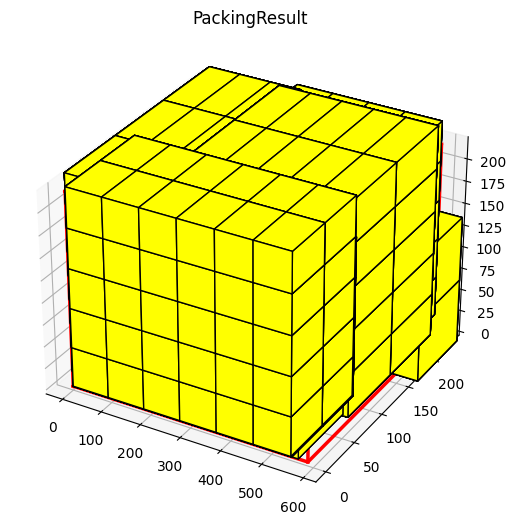

In [25]:
# E1-2
container = Space(0, 0, 0, 587, 233, 220)
box_list = [Box(91, 54, 45, 0), Box(105, 77, 72, 1), Box(79, 78, 48, 2)]
num_list = [32, 24, 30]
test(container, box_list, num_list,1)

剩余未装入的箱子：[0, 6, 20]
已装入车厢的体积：20512080.0
总箱体填满的比例：68.17%


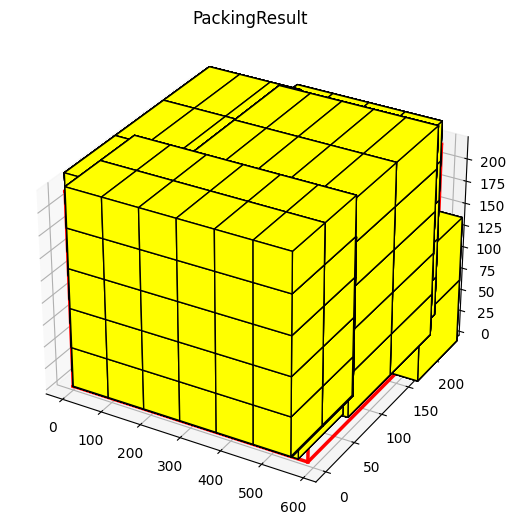

In [26]:
# E1-3
container = Space(0, 0, 0, 587, 233, 220)
box_list = [Box(91, 54, 45, 0), Box(105, 77, 72, 1), Box(79, 78, 48, 2)]
num_list = [32, 24, 30]
test(container, box_list, num_list,1)

In [5]:
# E1-4
container = Space(0, 0, 0, 587, 233, 220)
box_list = [Box(60, 40, 32, 0), Box(98, 75, 55, 1), Box(60, 59, 39, 2)]
num_list = [64, 40, 64]
test(container, box_list, num_list,0)

剩余未装入的箱子：[46, 4, 40]
已装入车厢的体积：19248840.0
总箱体填满的比例：63.97%


In [64]:
# E1-5
container = Space(0, 0, 0, 587, 233, 220)
box_list = [Box(78, 37, 27, 0), Box(89, 70, 25, 1), Box(90, 84, 41, 2)]
num_list = [63, 52, 55]
test(container, box_list, num_list,0)

剩余未装入的箱子：[0, 4, 42]
已装入车厢的体积：16414566.0
总箱体填满的比例：54.55%


### 测试数据E2：5种箱子

In [66]:
# E2-1
container = Space(0, 0, 0, 587, 233, 220)
box_list = [Box(108, 76, 30, 0), Box(110, 43, 25, 1), Box(92, 81, 55, 2), Box(81, 33, 28, 3), Box(120, 99, 73, 4)]
num_list = [24, 7, 22, 13, 15]
test(container, box_list, num_list,1)

剩余未装入的箱子：[0, 3, 21, 0, 2]
已装入车厢的体积：19039712.0
总箱体填满的比例：63.28%


In [67]:
# E2-2
container = Space(0, 0, 0, 587, 233, 220)
box_list = [Box(49, 25, 21, 0), Box(60, 51, 41, 1), Box(103, 76, 64, 2), Box(95, 70, 62, 3), Box(111, 49, 26, 4)]
num_list = [22, 22, 28, 25, 17]
test(container, box_list, num_list,1)

剩余未装入的箱子：[0, 2, 4, 19, 16]
已装入车厢的体积：17714172.0
总箱体填满的比例：58.87%


In [68]:
# E2-3
container = Space(0, 0, 0, 587, 233, 220)
box_list = [Box(88, 54, 39, 0), Box(94, 54, 36, 1), Box(87, 77, 43, 2), Box(100, 80, 72, 3), Box(83, 40, 36, 4)]
num_list = [25, 27, 21, 20, 24]
test(container, box_list, num_list,1)

剩余未装入的箱子：[2, 3, 21, 3, 8]
已装入车厢的体积：20352528.0
总箱体填满的比例：67.64%


In [6]:
# E2-4
container = Space(0, 0, 0, 587, 233, 220)
box_list = [Box(90, 70, 36, 0), Box(84, 78, 28, 1), Box(94, 85, 39, 2), Box(80, 76, 54, 3), Box(69, 50, 45, 4)]
num_list = [16, 28, 20, 23, 31]
test(container, box_list, num_list,1)

剩余未装入的箱子：[1, 0, 15, 3, 1]
已装入车厢的体积：21320718.0
总箱体填满的比例：70.86%


In [70]:
# E2-5
container = Space(0, 0, 0, 587, 233, 220)
box_list = [Box(74, 63, 61, 0), Box(71, 60, 25, 1), Box(106, 80, 59, 2), Box(109, 76, 42, 3), Box(118, 56, 22, 4)]
num_list = [22, 12, 25, 24, 11]
test(container, box_list, num_list,1)

剩余未装入的箱子：[0, 0, 13, 0, 10]
已装入车厢的体积：22033892.0
总箱体填满的比例：73.23%
